# Imbalanced datasets
------------------------------------

This example shows the different approaches we can take to handle imbalanced datasets.

The data used is a variation on the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The goal of this dataset is to predict whether or not it will rain tomorrow training a binay classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv('./datasets/weatherAUS.csv')

# Let's have a look at a subset of the data
X.sample(frac=1).iloc[:5, :8]

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed
86433,Cairns,14.7,26.4,0.0,5.0,7.6,ESE,35.0
5964,Cobar,23.8,39.9,0.0,12.6,13.2,S,31.0
18064,NorahHead,21.8,26.7,4.2,NaN,NaN,NNE,48.0
107088,Albany,19.5,25.9,0.0,5.2,12.2,NaN,NaN
79530,Dartmoor,9.6,14.2,11.8,1.4,0.1,SSW,37.0


## Run the pipeline

In [3]:
# Initialize ATOM with the created dataset
atom = ATOMClassifier(X, n_rows=0.3, test_size=0.3, verbose=2, random_state=1)
atom.clean()
atom.impute()
atom.encode()

<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ================== >>
Shape: (42658, 22)
Missing values: 95216
Categorical columns: 5
Scaled: False
-----------------------------------
Train set size: 29861
Test set size: 12797
-----------------------------------
Train set balance: No:Yes <==> 3.5:1.0
Test set balance: No:Yes <==> 3.4:1.0
-----------------------------------
Distribution of classes:
|     |   dataset |   train |   test |
|:----|----------:|--------:|-------:|
| No  |     33139 |   23247 |   9892 |
| Yes |      9519 |    6614 |   2905 |

Applying data cleaning...
 --> Label-encoding the target column.
Fitting Imputer...
Imputing missing values...
 --> Dropping 352 rows for containing less than 50% non-missing values.
 --> Dropping 92 rows due to missing values in feature MinTemp.
 --> Dropping 56 rows due to missing values in feature MaxTemp.
 --> Dropping 350 rows due to missing values in feature Rainfall.
 --> Dropp

In [4]:
# First, we fit a logistic regression model directly on the imbalanced data
atom.run("LR", metric="f1", bagging=5)


Training ===================================== >>
Models: LR
Metric: f1


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f1: 0.6174
Test evaluation --> f1: 0.6096
Time elapsed: 0.083s
Bagging -----------------------------------------
Evaluation --> f1: 0.6078 ± 0.0048
Time elapsed: 0.353s
-------------------------------------------------
Total time: 0.446s


Final results ========================= >>
Duration: 0.448s
------------------------------------------
Logistic Regression --> f1: 0.608 ± 0.005


## Class weights

In [5]:
# Add class weights through the est_params parameter
atom.run("LR_cw", est_params={"class_weight": atom.get_class_weight()}, bagging=5)


Training ===================================== >>
Models: LR_cw
Metric: f1


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f1: 0.6449
Test evaluation --> f1: 0.6472
Time elapsed: 0.080s
Bagging -----------------------------------------
Evaluation --> f1: 0.6483 ± 0.0014
Time elapsed: 0.334s
-------------------------------------------------
Total time: 0.423s


Final results ========================= >>
Duration: 0.424s
------------------------------------------
Logistic Regression --> f1: 0.648 ± 0.001


## Oversampling & undersampling

In [6]:
# Since we are going to use two different approaches that
# change the dataset, we will split atom in two branches

# We will use the current branch later for undersampling
atom.branch.rename("undersampling")

Branch renamed successfully!


In [7]:
atom.classes

,dataset,train,test
0,13189,9317,3872
1,3706,2555,1151


In [8]:
# And we need to create a new branch for oversampling
atom.branch = "oversampling"

New branch 'oversampling' successfully created!


In [9]:
# Perform oversampling of the minority class
atom.balance(strategy='smote', sampling_strategy=0.9)

Oversampling with SMOTE...
 --> Adding 5830 rows to class: Yes.


In [10]:
atom.classes  # Note the balanced training set!

,dataset,train,test
0,13189,9317,3872
1,9536,8385,1151


In [11]:
atom.run("LR_os", bagging=5)


Training ===================================== >>
Models: LR_os
Metric: f1


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f1: 0.7918
Test evaluation --> f1: 0.6505
Time elapsed: 0.107s
Bagging -----------------------------------------
Evaluation --> f1: 0.6489 ± 0.0031
Time elapsed: 0.405s
-------------------------------------------------
Total time: 0.523s


Final results ========================= >>
Duration: 0.524s
------------------------------------------
Logistic Regression --> f1: 0.649 ± 0.003


In [12]:
# Now, let's return to the undersampling branch
atom.branch = "undersampling"

# Note that here the data is still imbalanced!
atom.classes

Switched to branch 'undersampling'.


,dataset,train,test
0,13189,9317,3872
1,3706,2555,1151


In [13]:
# Perform undersampling of the majority class
atom.balance(strategy='NearMiss', sampling_strategy=0.9)

Undersampling with NearMiss...
 --> Removing 6479 rows from class: No.


In [14]:
atom.run("LR_us", bagging=5)


Training ===================================== >>
Models: LR_us
Metric: f1


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f1: 0.7829
Test evaluation --> f1: 0.6061
Time elapsed: 0.060s
Bagging -----------------------------------------
Evaluation --> f1: 0.6037 ± 0.0071
Time elapsed: 0.239s
-------------------------------------------------
Total time: 0.305s


Final results ========================= >>
Duration: 0.306s
------------------------------------------
Logistic Regression --> f1: 0.604 ± 0.007 ~


## Analyze results

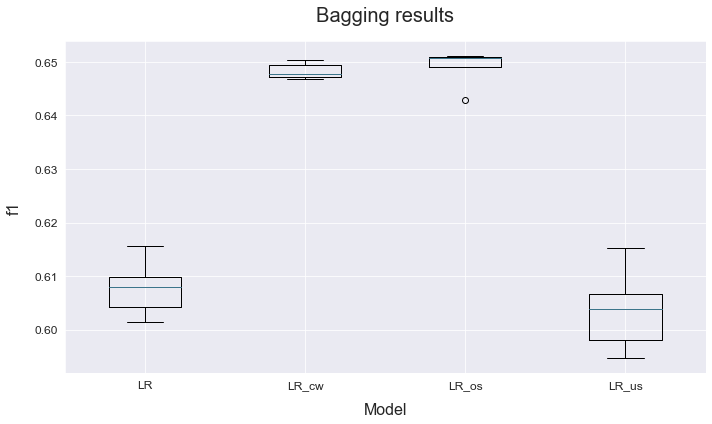

In [15]:
atom.plot_bagging()